In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [2]:

# Đọc dữ liệu
df = pd.read_csv('Gasoline RBOB.csv')

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)


C:\Users\DELL\AppData\Local\Temp\ipykernel_8888\3436067659.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekend_data.loc[len(weekend_data)] = new_row


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-02 00:00:00,1.63455,1.74155,1.757,1.7211,NaN,5.76
2,2019-03-03 00:00:00,1.7335,1.731,1.742,1.7298,NaN,12.89
3,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
4,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1915,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1916,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1917,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


In [4]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna()
df = df.reset_index(drop=True)

price = df['Price'].values
price = price.reshape(-1, 1)

In [5]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010.0,-1.37
1,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550.0,-10.41
2,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430.0,0.46
3,2019-03-06 00:00:00,1.5674,1.7604,1.7919,1.7524,91540.0,0.47
4,2019-03-07 00:00:00,1.5743,1.7845,1.816,1.7845,78590.0,0.44
...,...,...,...,...,...,...,...
1340,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20.0,1.53
1341,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330.0,-0.2
1342,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280.0,-1.78
1343,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440.0,-2.43


In [6]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Gasoline RBOB

## 7:3

In [7]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [8]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(price_scaled) * 0.7)
test_size = len(price_scaled) - train_size
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]


In [9]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [10]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [11]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [12]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [13]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.08754589659321717
MAPE trên tập test là: 2.797779772794006 %
MAE trên tập test là: 0.06862418021559559


In [14]:

# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)

Dự báo giá trị 90 ngày trong tương lai:
[[2.41917934]
 [2.42649446]
 [2.42637914]
 [2.42653539]
 [2.42460756]
 [2.42358208]
 [2.43417779]
 [2.46698764]
 [2.48626958]
 [2.50856136]
 [2.51072885]
 [2.51519659]
 [2.51615995]
 [2.51520827]
 [2.51526633]
 [2.51865635]
 [2.52139552]
 [2.52019995]
 [2.51595503]
 [2.51372901]
 [2.51636982]
 [2.51249424]
 [2.51587104]
 [2.51750746]
 [2.51673829]
 [2.51066787]
 [2.52131315]
 [2.51829454]
 [2.51965776]
 [2.52015618]
 [2.51973676]
 [2.51840863]
 [2.51873377]
 [2.51922932]
 [2.51698502]
 [2.52148497]
 [2.51991762]
 [2.51961992]
 [2.51606744]
 [2.51970032]
 [2.51991762]
 [2.51828045]
 [2.52024077]
 [2.518507  ]
 [2.52010347]
 [2.51898238]
 [2.51955176]
 [2.51991762]
 [2.51960485]
 [2.51955176]
 [2.51818328]
 [2.51955176]
 [2.5187307 ]
 [2.51955176]
 [2.51991762]
 [2.51955176]
 [2.51955176]
 [2.51905313]
 [2.51955176]
 [2.51905313]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.51955176]
 [2.5195

In [15]:

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.419179
1346,2.426494
1347,2.426379
1348,2.426535
1349,2.424608
...,...
1430,2.519552
1431,2.519552
1432,2.519552
1433,2.519552


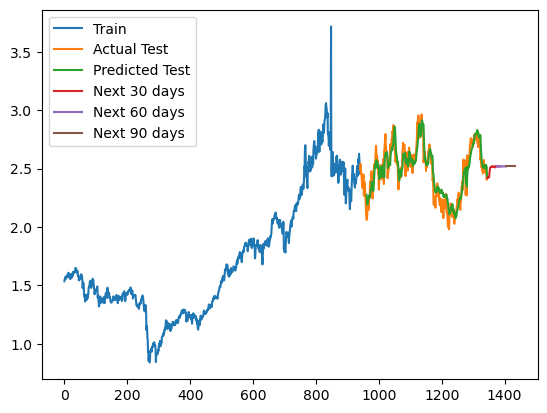

In [16]:

next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("RF_Gasoline_RBOB_Week6.png")

plt.legend()
plt.show()

## 8:2

In [17]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [18]:

# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [19]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [20]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [21]:

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.07485085264440346
MAPE trên tập test là: 2.3529346343817132 %
MAE trên tập test là: 0.056990480324307036


In [22]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.43184396]
 [2.4426722 ]
 [2.44213924]
 [2.43884448]
 [2.43177432]
 [2.43529293]
 [2.43937183]
 [2.44287534]
 [2.45125739]
 [2.45592899]
 [2.46346892]
 [2.47226898]
 [2.49211577]
 [2.51033282]
 [2.51791124]
 [2.52299872]
 [2.52399425]
 [2.52163494]
 [2.51209896]
 [2.51509662]
 [2.51211134]
 [2.50841488]
 [2.50805328]
 [2.50168072]
 [2.49783505]
 [2.49008189]
 [2.48778713]
 [2.49035615]
 [2.49706603]
 [2.50059048]
 [2.49800511]
 [2.50231868]
 [2.49953525]
 [2.5074981 ]
 [2.50710022]
 [2.51019971]
 [2.50924925]
 [2.51135777]
 [2.50886096]
 [2.50775719]
 [2.50596105]
 [2.5041653 ]
 [2.50230318]
 [2.49675996]
 [2.49977918]
 [2.49228393]
 [2.49572305]
 [2.49757573]
 [2.50049045]
 [2.50041236]
 [2.50105516]
 [2.50164485]
 [2.50385535]
 [2.50781092]
 [2.50570982]
 [2.50985632]
 [2.50663012]
 [2.50809335]
 [2.50671966]
 [2.50480344]
 [2.5041653 ]
 [2.50295743]
 [2.50159261]
 [2.49505221]
 [2.4973017 ]
 [2.49552946]
 [2.49957325]
 [2.49796219]
 [2.5031

In [23]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.431844
1346,2.442672
1347,2.442139
1348,2.438844
1349,2.431774
...,...
1430,2.498930
1431,2.501164
1432,2.499549
1433,2.504885


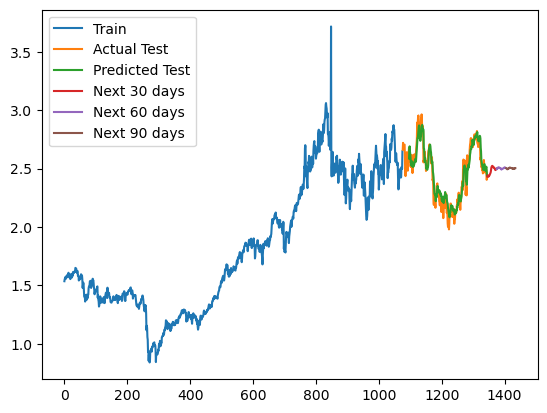

In [24]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()

### 9:1

In [25]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [26]:
# Hàm tạo tập dữ liệu với look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Định hình lại dữ liệu để phù hợp với mô hình
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [27]:
# Huấn luyện mô hình
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    random_state=42
)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=42)

In [28]:
# Dự báo 
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [29]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06854990624095841
MAPE trên tập test là: 2.0316745876377285 %
MAE trên tập test là: 0.04957674280028092


In [30]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat.reshape(-1,1), axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


Dự báo giá trị 90 ngày trong tương lai:
[[2.44017541]
 [2.45497422]
 [2.45986502]
 [2.45948232]
 [2.46987833]
 [2.49039241]
 [2.5125049 ]
 [2.51985316]
 [2.52374237]
 [2.53220311]
 [2.53231787]
 [2.53880784]
 [2.53755842]
 [2.53773805]
 [2.5271953 ]
 [2.52347451]
 [2.52665126]
 [2.52762274]
 [2.52587061]
 [2.53167826]
 [2.53512669]
 [2.53400106]
 [2.5409074 ]
 [2.54722891]
 [2.54751168]
 [2.54867507]
 [2.54812047]
 [2.54752025]
 [2.54825558]
 [2.5490229 ]
 [2.54704744]
 [2.54713226]
 [2.54827175]
 [2.54282825]
 [2.54179369]
 [2.54210814]
 [2.54372948]
 [2.5457266 ]
 [2.54943124]
 [2.55043359]
 [2.55044009]
 [2.55442115]
 [2.5580019 ]
 [2.56546652]
 [2.5680197 ]
 [2.57257348]
 [2.57429218]
 [2.57156376]
 [2.57354043]
 [2.57486978]
 [2.57085301]
 [2.57096643]
 [2.57374006]
 [2.5696393 ]
 [2.56943306]
 [2.56904204]
 [2.56981854]
 [2.5721912 ]
 [2.58029672]
 [2.58005938]
 [2.57974377]
 [2.58074693]
 [2.58332637]
 [2.58303127]
 [2.58315214]
 [2.58315214]
 [2.58367841]
 [2.58409676]
 [2.5840

In [31]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1345,2.440175
1346,2.454974
1347,2.459865
1348,2.459482
1349,2.469878
...,...
1430,2.577737
1431,2.580376
1432,2.580376
1433,2.582545


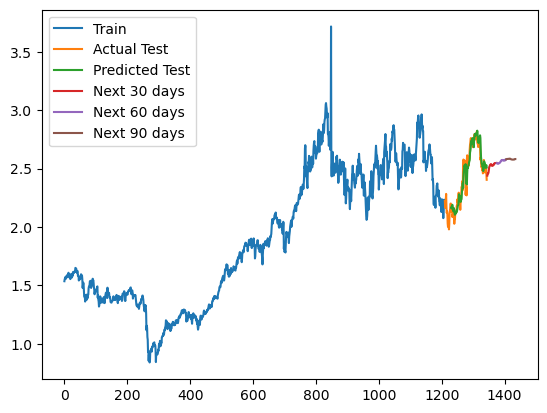

In [32]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.legend()
plt.show()